# Live Football Updates

Using the API made available by https://www.football-data.org/ we will apply the principals from the background notebook in the same directory as this notebook.  For this notebook to work, an environment variable called `FOOTBALL_DATA_ORG_API_TOKEN` must be set before loading this Jupyter notebook.  To get a token, go to https://www.football-data.org/client/register .

In [ ]:
# Enable PEP8 code checking.
%load_ext pycodestyle_magic

%pycodestyle_on

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from matplotlib.ticker import PercentFormatter
from scipy.stats import poisson

# Get the API token from the operating system environment.
api_token = os.environ['FOOTBALL_DATA_ORG_API_TOKEN']

headers = {'X-Auth-Token': api_token}
url = 'http://api.football-data.org/v2/competitions/2021/standings'
standings_response = requests.get(url, headers=headers)

url = 'http://api.football-data.org/v2/competitions/2021/matches'
url = f'{url}?status=SCHEDULED'
matches_response = requests.get(url, headers=headers)

In [46]:
standings = standings_response.json()['standings']
tables = {}

for standing in standings:
    if standing['type'] == 'HOME':
        tables['HOME'] = standing['table']
    elif standing['type'] == 'AWAY':
        tables['AWAY'] = standing['table']

data = {
    'AWAY': [],
    'HOME': []
}

for t in ['HOME', 'AWAY']:
    table = tables[t]

    for item in table:
        points = (item['won'] * 3) + item['draw']

        row = [
            item['team']['name'],
            item['playedGames'],
            item['won'],
            item['draw'],
            item['lost'],
            item['points'],
            item['goalsFor'],
            item['goalsAgainst'],
            item['goalDifference'],
            points
        ]

        data[t].append(row)

columns = list(item.keys())
columns.append('points')
columns.remove('position')

home_df = pd.DataFrame(data['HOME'], columns=columns)
away_df = pd.DataFrame(data['AWAY'], columns=columns)
home_df

,team,playedGames,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,points
0,Liverpool FC,14,14,0,0,42,38,11,27,42
1,Manchester City FC,13,9,2,2,29,33,12,21,29
2,Leicester City FC,14,8,3,3,27,26,15,11,27
3,Manchester United FC,14,7,5,2,26,27,12,15,26
4,Tottenham Hotspur FC,14,8,2,4,26,27,15,12,26
5,Everton FC,14,7,4,3,25,19,15,4,25
6,Arsenal FC,14,6,5,3,23,25,20,5,23
7,Burnley FC,14,7,1,6,22,19,18,1,22
8,Wolverhampton Wanderers FC,14,5,6,3,21,21,17,4,21
9,Chelsea FC,14,6,3,5,21,18,15,3,21


In [99]:
class Footy:
    def __init__(self):
        self._data = {}

    def add_team(self,
                 team_name,
                 goals_for,
                 goals_against,
                 home_games,
                 away_games):
        data = self.data()
        team_stats = {
            'goals_for': goals_for,
            'goals_against': goals_against,
            'home_games': home_games,
            'away_games': away_games
        }
        data[team_name] = team_stats
        self.data(data)

    def attack_strength(self, team_name):
        team_average_goals_scored = self.goals_scored(team_name)
        league_average_goals_scored = self.goals_scored()
        attack_strength = team_average_goals_scored
        attack_strength /= league_average_goals_scored
        return round(attack_strength, 2)

    def average_goals_scored(self, average_goals_scored=None):
        if average_goals_scored is not None:
            self._average_goals_scored = average_goals_scored
        return self._average_goals_scored

    def defence_factor(self, team_name):
        team_average_goals_conceeded = self.goals_conceeded(team_name)
        league_average_goals_conceeded = self.goals_conceeded()
        defence_factor = team_average_goals_conceeded
        defence_factor /= league_average_goals_conceeded
        return round(defence_factor, 2)

    def goals_conceeded(self, team_name=None):
        """
        Get the number of goals conceeded.

        Similar in nature to goals_scored.
        """
        data = self.data()

        if team_name:
            goals_conceeded_by_team = data[team_name]['goals_against']
            return goals_conceeded_by_team
        else:
            goals_conceeded = 0

            for team_name in data.keys():
                goals_conceeded += data[team_name]['goals_against']

            return int(round(goals_conceeded / len(data.keys())))

    def goals_scored(self, team_name=None):
        """
        Get the number of goals scored.

        If team_name is provided, the number of goals scored by
        that team is returned.  If not, the average number of
        goals scored by all teams is returned.
        """
        data = self.data()

        if team_name:
            goals_scored_by_team = data[team_name]['goals_for']
            return goals_scored_by_team
        else:
            goals_for = 0

            for team_name in data.keys():
                goals_for += data[team_name]['goals_for']

            return int(round(goals_for / len(data.keys())))

    def data(self, data=None):
        if data is not None:
            self._data = data
        return self._data

    def dataframe(self):
        a = []
        data = self.data()
        attack_strengths = []
        defence_factors = []

        for team_name in data.keys():
            team_dict = data[team_name]
            attack_strength = self.attack_strength(team_name)
            attack_strengths.append(attack_strength)
            defence_factor = self.defence_factor(team_name)
            defence_factors.append(defence_factor)
            team_list = [team_name]

            for value in list(team_dict.values()):
                team_list.append(value)

            a.append(team_list)

        columns = ['team_name']

        for key in list(team_dict.keys()):
            columns.append(key)

        df = pd.DataFrame(a, columns=columns)
        df['attack_strength'] = attack_strengths
        df['defence_factor'] = defence_factors
        return df

    def outcome_probability(self, home_team, away_team, show_plot=True):
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home > df.away]
        home_win_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home == df.away]
        draw_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home < df.away]
        away_win_probability = round(sum(df.probability.values), 2)

        if show_plot:
            labels = [f'{home_team} Win', 'Draw', f'{away_team} Win']
            sizes = [home_win_probability, draw_probability,
                     away_win_probability]

            fig1, ax1 = plt.subplots()
            ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                    shadow=True, startangle=90)
            # Equal aspect ratio ensures that pie is drawn as a circle.
            ax1.axis('equal')

            plt.show()

        return (home_win_probability, draw_probability, away_win_probability)

    def score_probability(self, home_team, away_team, show_plot=True):
        (home_expected_goals,
         away_expected_goals) = self.average_goals_scored()
        home_expected_goals *= self.attack_strength(home_team)
        home_expected_goals *= self.defence_factor(away_team)
        home_expected_goals = round(home_expected_goals, 2)
        goals = [0, 1, 2, 3, 4, 5, 6]
        probability_mass = poisson.pmf(goals, home_expected_goals)
        home_probability_mass = np.round(probability_mass, 2)
        away_expected_goals *= self.attack_strength(away_team)
        away_expected_goals *= self.defence_factor(home_team)
        away_expected_goals = round(away_expected_goals, 2)
        probability_mass = poisson.pmf(goals, away_expected_goals)
        away_probability_mass = np.round(probability_mass, 2)

        probabilities = []

        for home_team_goal in range(len(goals)):
            for away_team_goal in range(len(goals)):
                probability = home_probability_mass[home_team_goal]
                probability *= away_probability_mass[away_team_goal]
                probability = round(probability * 100.0, 2)
                probabilities.append([home_team_goal, away_team_goal,
                                      probability])

        if show_plot:
            x = np.arange(len(goals))  # the label locations
            width = 0.35  # the width of the bars

            fig, ax = plt.subplots()
            rects1 = ax.bar(x - width/2,
                            home_probability_mass,
                            width, label=home_team)
            rects2 = ax.bar(x + width/2,
                            away_probability_mass,
                            width, label=away_team)

            # Add some text for labels, title and custom x-axis
            # tick labels, etc.
            ax.set_ylabel('Probability')
            ax.set_xlabel('Potential Goals')
            ax.set_title(f'{home_team} v {away_team}')
            ax.set_xticks(x)
            ax.set_xticklabels(goals)
            ax.legend()
            fig.tight_layout()
            plt.show()

        df = pd.DataFrame(probabilities, columns=['home',
                                                  'away',
                                                  'probability'])
        df = df[df.probability != 0]
        df = df.sort_values('probability', ascending=False)
        df = df.reset_index(drop=True)
        return df


footy = Footy()

for team_name in sorted(list(home_df.team.values)):
    home_details = home_df.loc[home_df['team'] == team_name]
    away_details = away_df.loc[away_df['team'] == team_name]
    goals_for = home_details.goalsFor.values[0]
    goals_for += away_details.goalsFor.values[0]
    goals_against = home_details.goalsAgainst.values[0]
    goals_against += away_details.goalsAgainst.values[0]
    home_games = home_details.playedGames.values[0]
    away_games = away_details.playedGames.values[0]
    footy.add_team(team_name, goals_for, goals_against, home_games, away_games)

df = footy.dataframe()
df.sort_values(by=['attack_strength', 'defence_factor'], ascending=False)

,team_name,goals_for,goals_against,home_games,away_games,attack_strength,defence_factor
10,Manchester City FC,68,29,13,14,1.79,0.76
9,Liverpool FC,64,20,14,14,1.68,0.53
8,Leicester City FC,54,28,14,14,1.42,0.74
5,Chelsea FC,47,39,14,14,1.24,1.03
16,Tottenham Hotspur FC,46,39,14,14,1.21,1.03
11,Manchester United FC,42,30,14,14,1.11,0.79
19,Wolverhampton Wanderers FC,41,34,14,14,1.08,0.89
1,Arsenal FC,39,36,14,13,1.03,0.95
7,Everton FC,37,42,14,14,0.97,1.11
15,Southampton FC,35,51,14,14,0.92,1.34


In [100]:
total_goals_scored_by_home_team = home_df.goalsFor.sum()
total_home_games = home_df.playedGames.sum()
average_goals_scored_by_home_team = round(
    total_goals_scored_by_home_team / total_home_games, 2)
total_goals_scored_by_away_team = away_df.goalsFor.sum()
average_goals_scored_by_away_team = round(
    total_goals_scored_by_away_team / total_home_games, 2)
print(f'Total Goals Scored by Home Team: {total_goals_scored_by_home_team}')
print(f'Total Home Games Played: {total_home_games}')
print(
    f'Average Goals Scored by Home Team: {average_goals_scored_by_home_team}')
print(f'Total Goals Scored by Away Team: {total_goals_scored_by_away_team}')
print(
    f'Average Goals Scored by Away Team: {average_goals_scored_by_away_team}')
footy.average_goals_scored((average_goals_scored_by_home_team,
                            average_goals_scored_by_away_team))

Total Goals Scored by Home Team: 418
Total Home Games Played: 278
Average Goals Scored by Home Team: 1.5
Total Goals Scored by Away Team: 347
Average Goals Scored by Away Team: 1.25


(1.5, 1.25)

Match date 2020-03-07T12:30:00Z


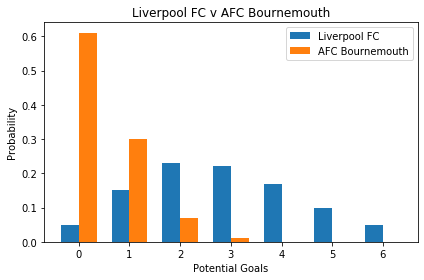

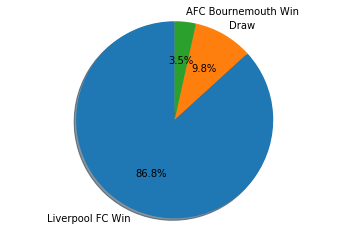

Match date 2020-03-07T15:00:00Z


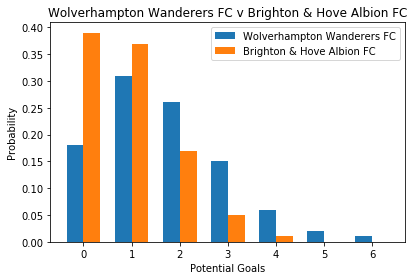

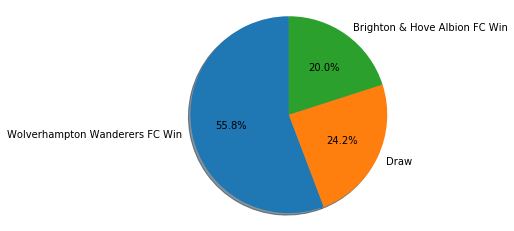

Match date 2020-03-07T15:00:00Z


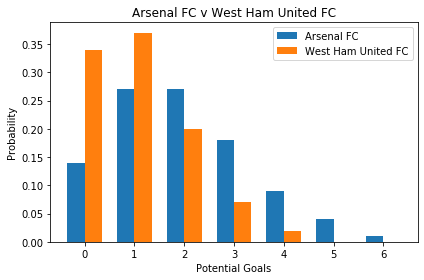

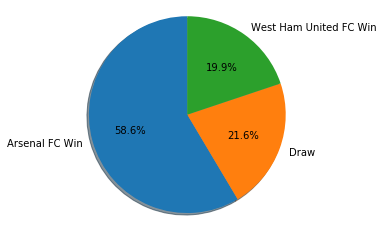

Match date 2020-03-07T15:00:00Z


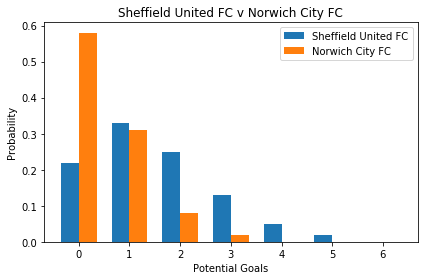

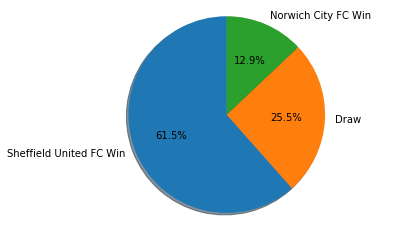

Match date 2020-03-07T15:00:00Z


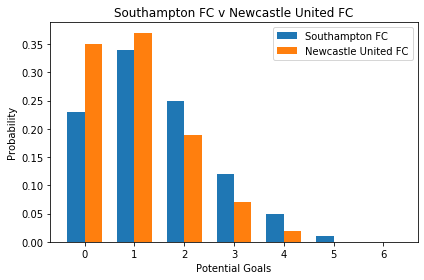

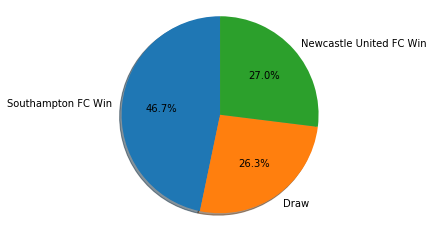

Match date 2020-03-07T15:00:00Z


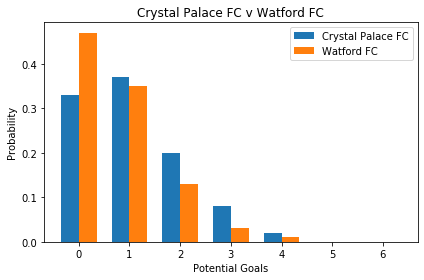

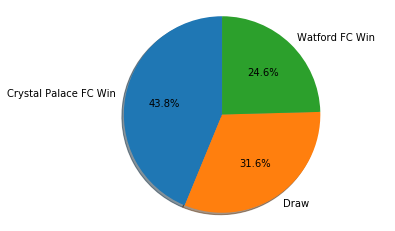

Match date 2020-03-07T17:30:00Z


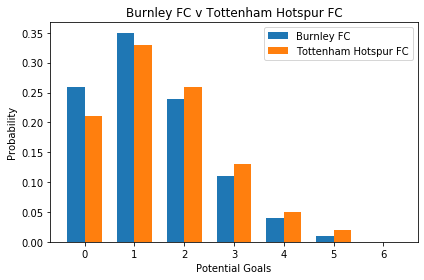

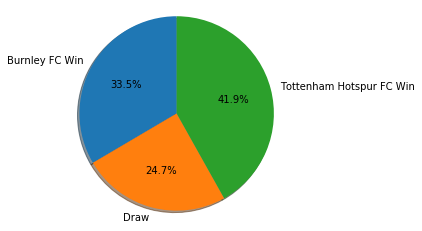

Match date 2020-03-08T14:00:00Z


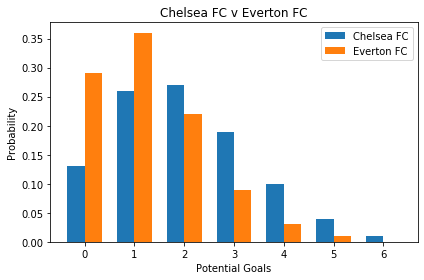

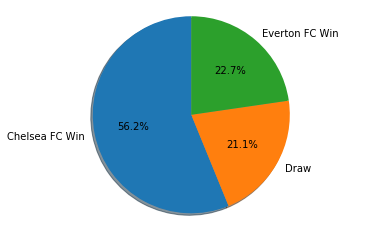

Match date 2020-03-08T16:30:00Z


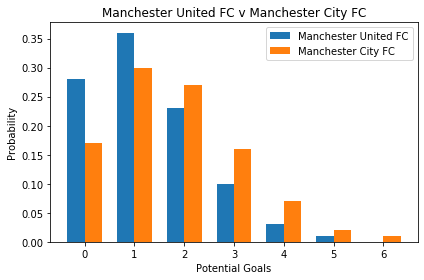

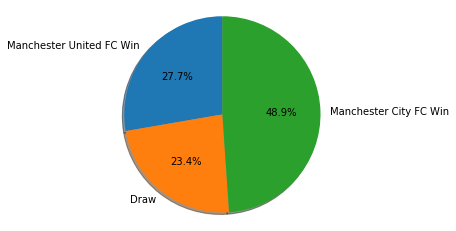

Match date 2020-03-09T20:00:00Z


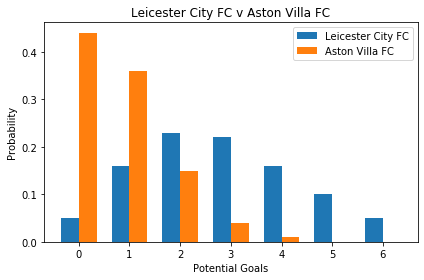

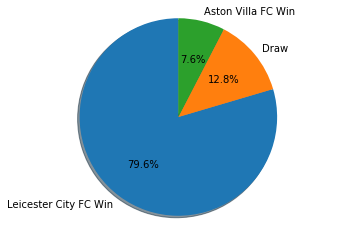

In [101]:
matches = matches_response.json()['matches']
teams = sorted(list(home_df.team.values))

for match in matches:
    utcDate = match['utcDate']
    home_team = match['homeTeam']['name']
    away_team = match['awayTeam']['name']
    print(f'Match date {utcDate}')
    footy.score_probability(home_team, away_team)
    footy.outcome_probability(home_team, away_team)

    if home_team in teams:
        teams.remove(home_team)

    if away_team in teams:
        teams.remove(away_team)

    if not len(teams):
        break